# ROMS model data

DOPPIO is a regional model (ROMS) run at rutgers by John Wilkin's group to forecast the state of the Gulf of Maine / mid atlantic bight. 


The data is available on a thredds server:

http://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/Averages_Best

## working with grids
This notebook is my attempt to learn about the ROMS grid and how to make plots. More below


In [2]:
import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

/Users/beaird/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


# read in the data

available at:
```python
url = 'http://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/Averages_Best'
```


In [3]:
url = 'http://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/Averages_Best'

ds = xr.open_dataset(url).sel(time = '2019-07-21', method = 'nearest').squeeze()

ds

<xarray.Dataset>
Dimensions:         (boundary: 4, eta_psi: 105, eta_rho: 106, eta_u: 106, eta_v: 105, s_rho: 40, s_w: 41, tracer: 2, xi_psi: 241, xi_rho: 242, xi_u: 241, xi_v: 242)
Coordinates:
  * s_rho           (s_rho) float64 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
  * s_w             (s_w) float64 -1.0 -0.975 -0.95 -0.925 ... -0.05 -0.025 0.0
    lon_rho         (eta_rho, xi_rho) float64 ...
    lat_rho         (eta_rho, xi_rho) float64 ...
    lon_u           (eta_u, xi_u) float64 ...
    lat_u           (eta_u, xi_u) float64 ...
    lon_v           (eta_v, xi_v) float64 ...
    lat_v           (eta_v, xi_v) float64 ...
    lon_psi         (eta_psi, xi_psi) float64 ...
    lat_psi         (eta_psi, xi_psi) float64 ...
    ocean_time      datetime64[ns] 2019-10-02T12:00:00
    time            datetime64[ns] 2019-07-21T12:00:00
    time_run        datetime64[ns] ...
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Dat

# Grids

ROMS uses a C-grid, common for ocean models, which means the the velocities, and scalars are actually on a different grid. In addition its vertical coordinate is not depth. These grid things really matter if we want to make plots of velocity, vertical slices, or calculate anything about our grid. 

I'm not *at all* an expert in modeling or these grids. I'm just interested in trying to make some simple plots. I've been looking at these resources to try to understand how to work with the ROMS grid in python:

xarray example: http://xarray.pydata.org/en/scipy19-docs/examples/ROMS_ocean_model.html

discussion on xgcm: https://github.com/xgcm/xgcm/issues/108

xgcm in general: https://xgcm.readthedocs.io/en/latest/index.html

I think in combo these sources are really helpful. I'm going to try to puzzle through working with the grid useing these ideas. 


# first, get a depth grid from s_rho:
following xarray example: http://xarray.pydata.org/en/scipy19-docs/examples/ROMS_ocean_model.html

If we want to plot anything vs depth we need to convert from `s_rho` to depth

$Z_0 = (h_c \, S + h \,C) / (h_c + h)$

$z = Z_0 (\zeta + h) + \zeta$


This transformation takes a while. Probably need to subset the data first so you don't do it on everything.

In [4]:

if ds.Vtransform == 1:
    Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
    z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
elif ds.Vtransform == 2:
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho

ds.coords['z_rho'] = z_rho.transpose()   # needing transpose seems to be an xarray bug
ds.salt

<xarray.DataArray 'salt' (s_rho: 40, eta_rho: 106, xi_rho: 242)>
[1026080 values with dtype=float64]
Coordinates:
  * s_rho       (s_rho) float64 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
    lon_rho     (eta_rho, xi_rho) float64 -75.19 -75.13 -75.08 ... -64.62 -64.54
    lat_rho     (eta_rho, xi_rho) float64 32.24 32.28 32.32 ... 46.58 46.61
    ocean_time  datetime64[ns] 2019-10-02T12:00:00
    time        datetime64[ns] 2019-07-21T12:00:00
    time_run    datetime64[ns] 2019-07-20T12:00:00
    z_rho       (s_rho, xi_rho, eta_rho) float64 -3.838e+03 -3.788e+03 ... nan
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:      time-averaged salinity
    time:           ocean_time
    grid:           grid
    location:       face
    field:          salinity, scalar, series
    _ChunkSizes:    [  1  20  53 121]
    standard_name:  sea_water_salinity

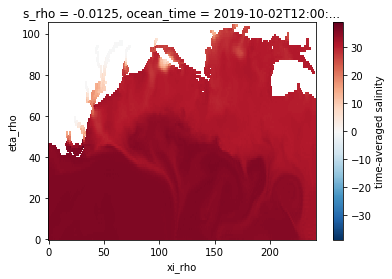

In [6]:
plt.figure()
ds.salt.sel(s_rho=0, method='nearest').plot()


# plot a vertical slice

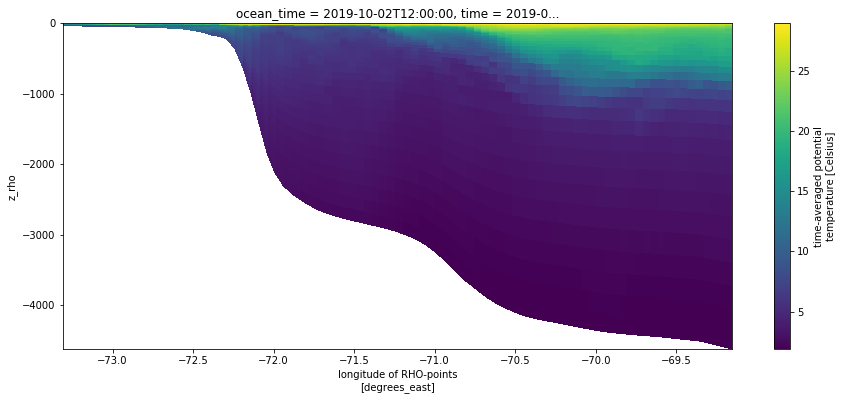

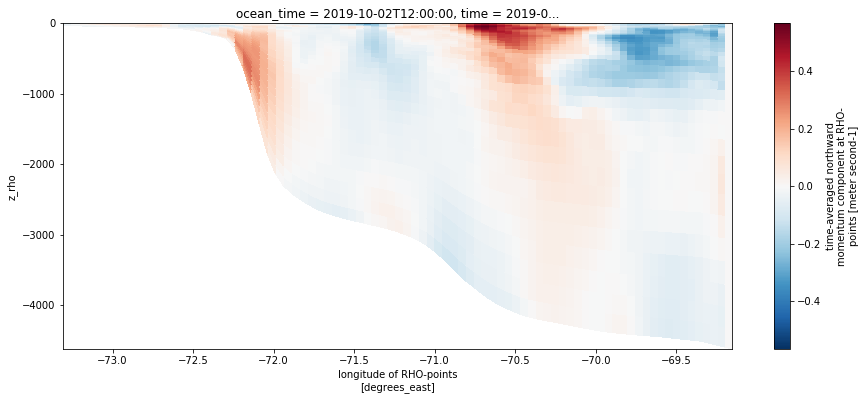

In [15]:
section = ds.temp.isel(xi_rho=100, eta_rho=slice(0, 85)) # can't go into the nan coords and have the plot work...
section.plot(x='lon_rho', y='z_rho', figsize=(15, 6))
# plt.ylim([-100, 1]);


section = ds.v_northward.isel(xi_rho=100, eta_rho=slice(0, 85)) # can't go into the nan coords and have the plot work...
section.plot(x='lon_rho', y='z_rho', figsize=(15, 6))

In [ ]:
# fig = plt.figure(figsize=(9,6))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines(resolution='50m')

# gl = ax.gridlines(draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
# gl.xlabels_top = gl.ylabels_right = False
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER

# plt.quiver(subset.lon_rho, subset.lat_rho , subset.u_eastward, 
#            subset.v_northward, subset.v_northward, cmap='RdBu',
#            transform=ccrs.PlateCarree())

# plt.colorbar()